## Goal

To produce datapoints in 7d space by building 7-spheres in all orthants (2 concentric spheres of radii, say, 1 and 2 in all orthants,
centered at say, a distance of 4 from all axes) in a non-uniform fashion, i.e., some orthants would have fewer points and some more points
(say, 25% of the orthants have fewer points, perhaps ~25 points in most orthants and ~4 points in the rarer orthants).

We wish to determine the performance of a neural network for different orthants - does it perform equally well or similar in all orthants,
determining that there is symmetry present in the data? Or does it fail to do so, doing well only in the orthants with more data? We use a
validation set of say, 4 points per orthant to quantify each orthant's performance.

## Data

### Defining constants

In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
SIGNS = [-1., 1.] 

ORTHANTS = torch.stack(
    [torch.tensor([s1, s2, s3, s4, s5, s6, s7])
    for s1 in SIGNS
    for s2 in SIGNS
    for s3 in SIGNS
    for s4 in SIGNS
    for s5 in SIGNS
    for s6 in SIGNS
    for s7 in SIGNS])   # Representing each orthant as the sign of each of its 7 coordinates/wrt each of its 7 axes
ORTHANTS.shape

torch.Size([128, 7])

In [4]:
LOW_COUNT = 4   # Average no. of points in a "rare" orthant
HIGH_COUNT = 25 # Average no. of points in a "typical" orthant
LOW_SPREAD = 2  # Allowed unidirectional deviation for no. of points in a "rare" orthant (i.e., 2 to 6 points)
HIGH_SPREAD = 8 # Allowed unidirectional deviation for no. of points in a "typical" orthant (i.e., 17 to 33 points)
VAL_COUNT = 4   # Validation data points per orthant
TEST_COUNT = 64 # Test data points per orthant, for final pattern
LOW_FRAC = 0.25 # Number of "rare" orthants

In [5]:
HIGH_ORTHANTS, LOW_ORTHANTS = train_test_split(ORTHANTS, test_size=LOW_FRAC)
# Randomly choosing the "rare" orthants
HIGH_ORTHANTS.shape, LOW_ORTHANTS.shape

(torch.Size([96, 7]), torch.Size([32, 7]))

In [6]:
CENTRE = 4 * torch.ones(7)
# The centre of the 7-spheres, without orthant-specificity, which can be included using ORTHANTS
CENTRE

tensor([4., 4., 4., 4., 4., 4., 4.])

In [7]:
LOW_RADIUS = 1. # Radius of the inner sphere (say, label 0) in each orthant
HIGH_RADIUS = 2.    # Radius of the outer sphere (say, label 1) in each orthant

### Data generation

Now, we describe a 7-sphere using the standard notation. <br>
Say, it is centered at $C = (C_1, C_2, ..., C_7)$ and has radius $r$. Each point can be described with the help of 6 angles, <br>
$\phi_1$, $\phi_2$, $\phi_3$, $\phi_4$, $\phi_5$, and $\phi_6$, where $\phi_6 \in [0, 2\pi)$ and $\phi_1, ..., \phi_5 \in [0, \pi]$ <br>
Any point $x = (x_1, x_2, ..., x_7)$ on the sphere can be described as follows: <br>
$x_1 = C_1 + r\cos(\phi_1)$ <br>
$x_2 = C_2 + r\sin(\phi_1)\cos(\phi_2)$ <br>
$x_3 = C_3 + r\sin(\phi_1)\sin(\phi_2)\cos(\phi_3)$ <br>
$x_4 = C_4 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\cos(\phi_4)$ <br>
$x_5 = C_5 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\sin(\phi_4)\cos(\phi_5)$ <br>
$x_6 = C_6 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\sin(\phi_4)\sin(\phi_5)\cos(\phi_6)$ <br>
$x_7 = C_7 + r\sin(\phi_1)\sin(\phi_2)\sin(\phi_3)\sin(\phi_4)\sin(\phi_5)\sin(\phi_6)$
<br>

Hence, each datapoint will be sampled by randomly generating the 6 angles from appropriate uniform distributions and 
performing the mentioned transformation

In [8]:
def generate_point(
    radius: float,
    orthant: torch.Tensor
) -> torch.Tensor:
    """
    Generates a point on a 7-sphere of centre orthant * CENTRE (global) with radius radius, where
    orthant denotes the signs wrt all 7 axes

    Args:
        radius (float): radius of the 7-sphere
        orthant (torch.Tensor): signs wrt the 7 axes for the resulting point, of shape (7,)
    
    Returns:
        x (torch.Tensor): a point on the specified sphere, of shape (7,)
    
    Example usage:
    >>> generate_point(2, tensor([1., 1., 1., 1., 1., 1., 1.]))
    tensor([2., 4., 4., 4., 4., 4., 4.])
    """
    phi = torch.rand((6,)) * torch.pi
    phi[5] *= 2
    diff_unit = torch.tensor([
        torch.cos(phi[0]),
        torch.sin(phi[0])*torch.cos(phi[1]),
        torch.sin(phi[0])*torch.sin(phi[1])*torch.cos(phi[2]),
        torch.sin(phi[0])*torch.sin(phi[1])*torch.sin(phi[2])*torch.cos(phi[3]),
        torch.sin(phi[0])*torch.sin(phi[1])*torch.sin(phi[2])*torch.sin(phi[3])*torch.cos(phi[4]),
        torch.sin(phi[0])*torch.sin(phi[1])*torch.sin(phi[2])*torch.sin(phi[3])*torch.sin(phi[4])*torch.cos(phi[5]),
        torch.sin(phi[0])*torch.sin(phi[1])*torch.sin(phi[2])*torch.sin(phi[3])*torch.sin(phi[4])*torch.sin(phi[5])
    ])
    return torch.mul(CENTRE + radius * diff_unit, orthant)
    

In [9]:
# Testing correctness

random_point = generate_point(2, ORTHANTS[0])
random_point, ((random_point - ORTHANTS[0]*CENTRE)**2).sum().sqrt()

(tensor([-5.7827, -4.4473, -3.2621, -3.8523, -4.0492, -4.1172, -3.8017]),
 tensor(2.))

#### Train data

In [10]:
X_train_low_0 = torch.cat([
    torch.cat([
        generate_point(1, orthant).reshape(1, -1) for i in range(int((2*torch.rand(1) - 1) * LOW_SPREAD + LOW_COUNT))
    ]) for orthant in LOW_ORTHANTS
])
X_train_low_1 = torch.cat([
    torch.cat([
        generate_point(2, orthant).reshape(1, -1) for i in range(int((2*torch.rand(1) - 1) * LOW_SPREAD + LOW_COUNT))
    ]) for orthant in LOW_ORTHANTS
])
X_train_high_0 = torch.cat([
    torch.cat([
        generate_point(1, orthant).reshape(1, -1) for i in range(int((2*torch.rand(1) - 1) * HIGH_SPREAD + HIGH_COUNT))
    ]) for orthant in HIGH_ORTHANTS
])
X_train_high_1 = torch.cat([
    torch.cat([
        generate_point(2, orthant).reshape(1, -1) for i in range(int((2*torch.rand(1) - 1) * HIGH_SPREAD + HIGH_COUNT))
    ]) for orthant in HIGH_ORTHANTS
])
X_train_low_0.shape, X_train_low_1.shape, X_train_high_0.shape, X_train_high_1.shape

(torch.Size([124, 7]),
 torch.Size([114, 7]),
 torch.Size([2344, 7]),
 torch.Size([2313, 7]))

In [11]:
Y_train_low_0 = torch.zeros(len(X_train_low_0), 1)
Y_train_low_1 = torch.ones(len(X_train_low_1), 1)
Y_train_high_0 = torch.zeros(len(X_train_high_0), 1)
Y_train_high_1 = torch.ones(len(X_train_high_1), 1)
Y_train_low_0.shape, Y_train_low_1.shape, Y_train_high_0.shape, Y_train_high_1.shape

(torch.Size([124, 1]),
 torch.Size([114, 1]),
 torch.Size([2344, 1]),
 torch.Size([2313, 1]))

In [12]:
X_train = torch.cat([
    X_train_low_0,
    X_train_low_1,
    X_train_high_0,
    X_train_high_1
])
Y_train = torch.cat([
    Y_train_low_0,
    Y_train_low_1,
    Y_train_high_0,
    Y_train_high_1
])
X_train.shape, Y_train.shape

(torch.Size([4895, 7]), torch.Size([4895, 1]))

In [13]:
def find_orthant(point: torch.Tensor) -> int:
    """
    Given a point, determines the orthant it lies in as an index of ORTHANTS

    Args:
        point (torch.Tensor): A random point in 7d space, a tensor of shape (7,)
    
    Returns:
        orthant_no (int): The index of ORTHANTS corresponding to the orthant point lies in
            i.e., orthant_no satisfies ORTHANTS[orthant_no] == torch.sign(point)
    
    Example usage:
    >>> find_orthant(tensor([1., 3., -2., -4., 3., 2.2, -9.]))
    102
    """
    orthant_no = 0
    for dim in point:
        orthant_no *= 2
        if dim > 0:
            orthant_no += 1
    return int(orthant_no)

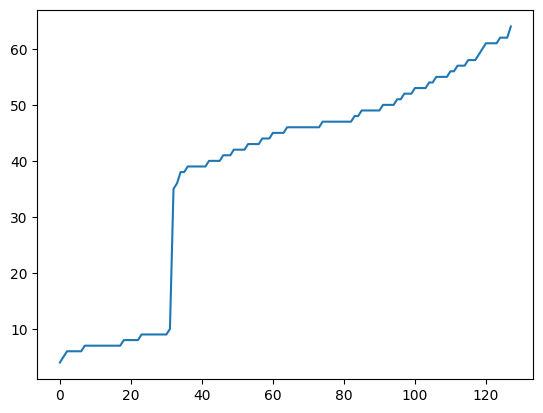

In [14]:
orthant_counts = torch.zeros(128)
for x in X_train:
    orthant_counts[find_orthant(x)] += 1
plt.plot(range(128), torch.sort(orthant_counts).values)

In [75]:
LOW_ORTHANT_INDICES = [find_orthant(orthant) for orthant in LOW_ORTHANTS]
HIGH_ORTHANT_INDICES = [find_orthant(orthant) for orthant in HIGH_ORTHANTS]

#### Validation data

In [15]:
X_val_0 = torch.cat([
    torch.cat([
        generate_point(1, orthant).reshape(1, -1) for i in range(VAL_COUNT)
    ]) for orthant in ORTHANTS
])
X_val_1 = torch.cat([
    torch.cat([
        generate_point(2, orthant).reshape(1, -1) for i in range(VAL_COUNT)
    ]) for orthant in ORTHANTS
])
Y_val_0 = torch.zeros(len(X_val_0), 1)
Y_val_1 = torch.ones(len(X_val_1), 1)
X_val_0.shape, X_val_1.shape, Y_val_0.shape, Y_val_1.shape

(torch.Size([512, 7]),
 torch.Size([512, 7]),
 torch.Size([512, 1]),
 torch.Size([512, 1]))

In [16]:
X_val = torch.cat([X_val_0, X_val_1])
Y_val = torch.cat([Y_val_0, Y_val_1])
X_val.shape, Y_val.shape

(torch.Size([1024, 7]), torch.Size([1024, 1]))

#### Test data

In [17]:
X_test = torch.cat([
    torch.cat([
        torch.cat([
            generate_point(1, orthant).reshape(1, -1) for i in range(TEST_COUNT)
        ]),
        torch.cat([
            generate_point(2, orthant).reshape(1, -1) for i in range(TEST_COUNT)
        ])
    ]).reshape(1, 2*TEST_COUNT, 7) for orthant in ORTHANTS
])
Y_test = torch.cat([
    torch.cat([
        torch.zeros(TEST_COUNT, 1),
        torch.ones(TEST_COUNT, 1)
    ]).reshape(1, 2*TEST_COUNT, 1) for orthant in ORTHANTS
])
X_test.shape, Y_test.shape

(torch.Size([128, 128, 7]), torch.Size([128, 128, 1]))

## Model

In [18]:
device = 'cpu'

In [19]:
from torch import nn

class SimpleNN(nn.Module):
    def __init__(
        self,
        hidden_layers: int = 2,
        hidden_units: int = 32
    ) -> None:
        super().__init__()
        self.input = nn.Sequential(
            nn.Linear(in_features=7, out_features=hidden_units),
            nn.ReLU()
        )
        self.hidden = nn.Sequential()
        for i in range(hidden_layers):
            self.hidden.append(nn.Linear(in_features=hidden_units, out_features=hidden_units))
            self.hidden.append(nn.ReLU())
        self.output = nn.Sequential(
            nn.Linear(in_features=hidden_units, out_features=1),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.output(self.hidden(self.input(x)))


In [20]:
from scripts.utils import make_dataloader

train_dataloader, val_dataloader = make_dataloader(X_train, Y_train, batch_size=32, shuffle=True), make_dataloader(X_val, Y_val, batch_size=32, shuffle=True)

In [25]:
depths = [2, 3, 4]
widths = [16, 32, 64]
lambdas = [0, 1e-5]
etas = [1e-3]
betass = [(0.9, 0.999), (0.8, 0.9)]

In [26]:
best_depth = None
best_width = None
best_lambda = None
best_eta = None
best_betas = None
best_score = -1

In [27]:
from scripts.metrics import BinaryAccuracy
from scripts.train import train_model
from scripts.test import predict

count = 0
total = len(depths) * len(widths) * len(lambdas) * len(etas) * len(betass)
EPOCHS = 32
for depth in depths:
    for width in widths:
        for lambda_i in lambdas:
            for eta in etas:
                for betas in betass:
                    model = SimpleNN(hidden_layers=depth, hidden_units=width).to(device)
                    loss_fn = torch.nn.BCELoss()
                    optimizer = torch.optim.Adam(params=model.parameters(), lr=eta, betas=betas, weight_decay=lambda_i)
                    metric = BinaryAccuracy()
                    history = train_model(
                        model=model,
                        train_dataloader=train_dataloader,
                        val_dataloader=val_dataloader,
                        loss_fn=loss_fn,
                        optimizer=optimizer,
                        metric=metric,
                        epochs=EPOCHS,
                        verbose=0,
                        device=device
                    )
                    count += 1
                    score = history['val_score'][-1]
                    print(f'Model {count} of {total} trained. Validation accuracy: {score}')
                    if score > best_score:
                        best_score = score
                        best_depth = depth
                        best_width = width
                        best_lambda = lambda_i
                        best_eta = eta
                        best_betas = betas

print(f'Results:\nDepth: {best_depth}\nWidth: {best_width}\nLambda: {best_lambda}\nEta: {best_eta}\nBetas: {best_betas}\nAccuracy after {EPOCHS} epochs: {best_score}')

Model 1 of 36 trained. Validation accuracy: 0.5712890625
Model 2 of 36 trained. Validation accuracy: 0.5546875
Model 3 of 36 trained. Validation accuracy: 0.5478515625
Model 4 of 36 trained. Validation accuracy: 0.537109375
Model 5 of 36 trained. Validation accuracy: 0.6767578125
Model 6 of 36 trained. Validation accuracy: 0.564453125
Model 7 of 36 trained. Validation accuracy: 0.7734375
Model 8 of 36 trained. Validation accuracy: 0.740234375
Model 9 of 36 trained. Validation accuracy: 0.8701171875
Model 10 of 36 trained. Validation accuracy: 0.7822265625
Model 11 of 36 trained. Validation accuracy: 0.8408203125
Model 12 of 36 trained. Validation accuracy: 0.80078125
Model 13 of 36 trained. Validation accuracy: 0.6337890625
Model 14 of 36 trained. Validation accuracy: 0.6181640625
Model 15 of 36 trained. Validation accuracy: 0.66015625
Model 16 of 36 trained. Validation accuracy: 0.564453125
Model 17 of 36 trained. Validation accuracy: 0.7734375
Model 18 of 36 trained. Validation accur

In [28]:
best_model = SimpleNN(hidden_layers=best_depth, hidden_units=best_width).to(device)

In [29]:
from scripts.metrics import BinaryAccuracy

loss_fn = torch.nn.BCELoss()
optimizer = torch.optim.Adam(params=best_model.parameters(), lr=best_eta, betas=best_betas, weight_decay=best_lambda)
metric = BinaryAccuracy()

In [30]:
from scripts.utils import EarlyStopping

early_stop = EarlyStopping(patience=20, min_delta=1e-4)

In [31]:
from scripts.train import train_model

history = train_model(
    model=best_model,
    train_dataloader=train_dataloader,
    val_dataloader=val_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    metric=metric,
    epochs=500,
    early_stopping=early_stop,
    device=device
)

Training model for 500 epochs. Early stopping enabled.
Epoch: 1 => Train loss: 0.696232, Train score: 0.504171, Val loss: 0.694596, Val score: 0.495117
Epoch: 2 => Train loss: 0.693352, Train score: 0.515029, Val loss: 0.694245, Val score: 0.505859
Epoch: 3 => Train loss: 0.691444, Train score: 0.534004, Val loss: 0.694190, Val score: 0.511719
Epoch: 4 => Train loss: 0.690382, Train score: 0.539334, Val loss: 0.695352, Val score: 0.503906
Epoch: 5 => Train loss: 0.690212, Train score: 0.534413, Val loss: 0.696530, Val score: 0.499023
Epoch: 6 => Train loss: 0.688597, Train score: 0.536448, Val loss: 0.695470, Val score: 0.505859
Epoch: 7 => Train loss: 0.685969, Train score: 0.552189, Val loss: 0.692830, Val score: 0.523438
Epoch: 8 => Train loss: 0.682306, Train score: 0.560339, Val loss: 0.689466, Val score: 0.537109
Epoch: 9 => Train loss: 0.670360, Train score: 0.597519, Val loss: 0.671873, Val score: 0.585938
Epoch: 10 => Train loss: 0.645428, Train score: 0.626166, Val loss: 0.66

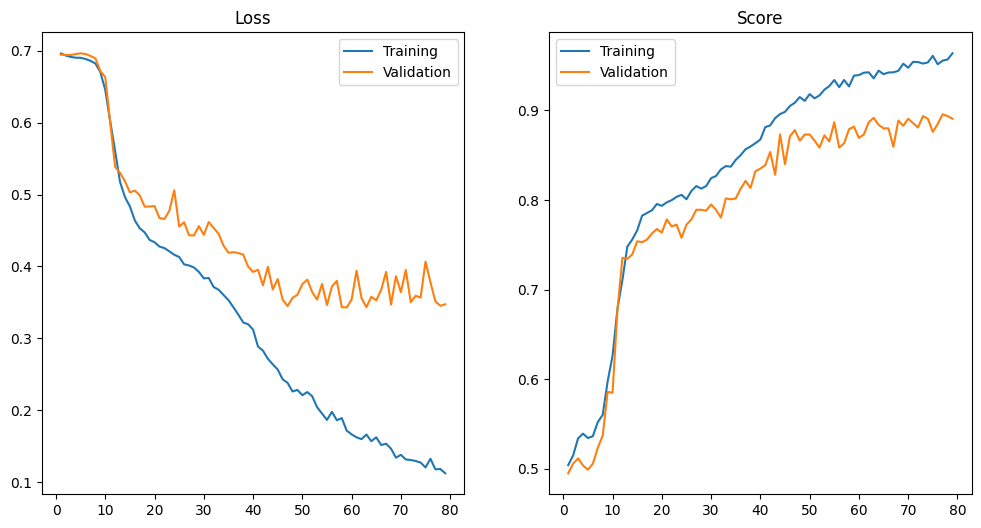

In [32]:
from scripts.utils import plot_train_history

plot_train_history(history)

In [79]:
from scripts.test import predict

scores = torch.tensor([
    metric(
        predict(best_model, X_test[i], device),
        Y_test[i]
    ) for i in range(128)
])

## Orthant performance plot

Text(0.5, 1.0, 'Score vs no. of points for each orthant')

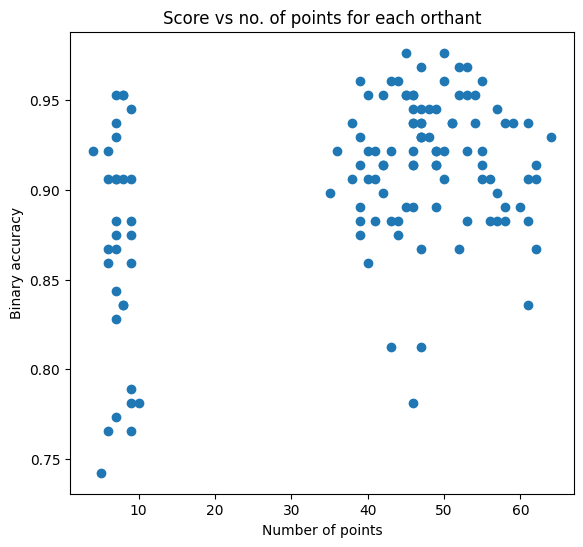

In [80]:
plt.figure(figsize=(6.5, 6))
plt.scatter(orthant_counts, scores)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.title('Score vs no. of points for each orthant')

In [81]:
from scipy.stats import pearsonr

pearsonr(orthant_counts, scores).statistic

0.4069567613482996

In [82]:
scores.mean() # also try getting score for LOW_ORTHANTS and HIGH_ORTHANTS

tensor(0.9043)

In [83]:
print('Performance in rare orthants: ', scores[LOW_ORTHANT_INDICES].mean())
print('Performance in typical orthants: ', scores[HIGH_ORTHANT_INDICES].mean())

Performance in rare orthants:  tensor(0.8674)
Performance in typical orthants:  tensor(0.9166)


Okay, maybe a neural network can find symmetry? Can an SVM do this too? Is the test data too similar to training?

## SVM

In [59]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, make_scorer
from scripts.ntk import NTK
from sklearn.model_selection import GridSearchCV

In [60]:
ntk = NTK(best_model).get_ntk

In [61]:
model_base = SVC(kernel=ntk)
params = {
    'C': np.logspace(-3, 3, 7)
}
scorer = make_scorer(accuracy_score)

In [64]:
model_cv = GridSearchCV(
    estimator=model_base,
    param_grid=params,
    scoring=scorer,
    n_jobs=5,
    verbose=3
)
model_cv.fit(X_train, Y_train.squeeze())
model_cv.best_params_

Fitting 5 folds for each of 7 candidates, totalling 35 fits
[CV 3/5] END ...........................C=0.001;, score=0.527 total time=  12.0s
[CV 2/5] END ...........................C=0.001;, score=0.572 total time=  12.2s
[CV 5/5] END ...........................C=0.001;, score=0.518 total time=  12.3s
[CV 1/5] END ...........................C=0.001;, score=0.554 total time=  12.4s
[CV 4/5] END ...........................C=0.001;, score=0.546 total time=  12.4s
[CV 1/5] END ............................C=0.01;, score=0.600 total time=  11.5s
[CV 5/5] END ............................C=0.01;, score=0.549 total time=  11.8s
[CV 3/5] END ............................C=0.01;, score=0.558 total time=  12.0s
[CV 4/5] END ............................C=0.01;, score=0.593 total time=  12.1s
[CV 2/5] END ............................C=0.01;, score=0.609 total time=  12.3s
[CV 1/5] END .............................C=0.1;, score=0.634 total time=  11.0s
[CV 3/5] END .............................C=0.1;,

{'mean_fit_time': array([ 8.53114305,  8.25963769,  8.41696944,  8.74220028,  9.3415092 ,
        10.20952868, 10.80746679]),
 'std_fit_time': array([0.05142901, 0.22357577, 0.40626035, 0.68599528, 0.71963623,
        0.66636705, 0.67545489]),
 'mean_score_time': array([3.74027739, 3.69900303, 3.54811735, 3.67932692, 3.6407352 ,
        3.45474143, 3.31378608]),
 'std_score_time': array([0.16143654, 0.10571274, 0.23753848, 0.2823331 , 0.38085871,
        0.08874535, 0.10980251]),
 'param_C': masked_array(data=[0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0],
              mask=[False, False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'C': 0.001},
  {'C': 0.01},
  {'C': 0.1},
  {'C': 1.0},
  {'C': 10.0},
  {'C': 100.0},
  {'C': 1000.0}],
 'split0_test_score': array([0.55362615, 0.59959142, 0.63432074, 0.70888662, 0.7773238 ,
        0.81818182, 0.85597549]),
 'split1_test_score': array([0.57201226, 0.60878447, 0.64453524, 0.75995914,

In [65]:
model = model_cv.best_estimator_

In [66]:
model.fit(X_train, Y_train.squeeze())

SVC(C=1000.0,
    kernel=<bound method NTK.get_ntk of <scripts.ntk.NTK object at 0x7f12c0fbb7f0>>)

In [67]:
preds_train, preds_val = model.predict(X_train), model.predict(X_val)
score_train, score_val = accuracy_score(Y_train.squeeze(), preds_train), accuracy_score(Y_val.squeeze(), preds_val)
score_train, score_val

(0.9867211440245148, 0.8701171875)

In [84]:
scores = np.array([
    accuracy_score(
        model.predict(X_test[i]),
        Y_test[i].squeeze()
    ) for i in range(128)
])

Text(0.5, 1.0, 'Score vs no. of points for each orthant')

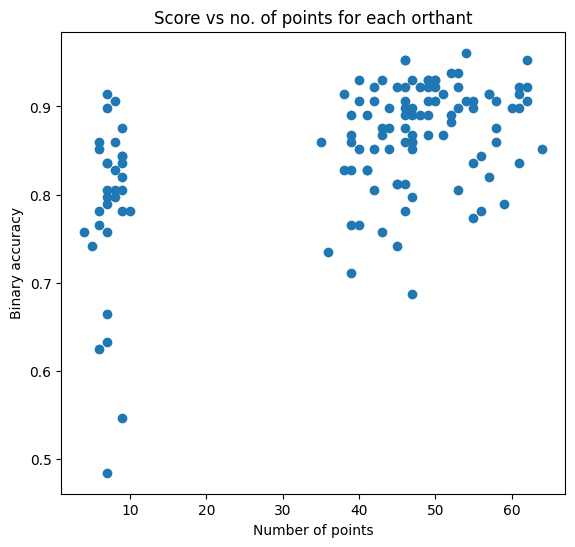

In [85]:
plt.figure(figsize=(6.5, 6))
plt.scatter(orthant_counts, scores)
plt.xlabel('Number of points')
plt.ylabel('Binary accuracy')
plt.title('Score vs no. of points for each orthant')

In [86]:
from scipy.stats import pearsonr

pearsonr(orthant_counts, scores).statistic

0.5045467567022635

In [87]:
scores.mean()

0.84991455078125

In [88]:
print('Performance in rare orthants: ', scores[LOW_ORTHANT_INDICES].mean())
print('Performance in typical orthants: ', scores[HIGH_ORTHANT_INDICES].mean())

Performance in rare orthants:  0.78515625
Performance in typical orthants:  0.8715006510416666
